In [ ]:
# !pip install vnstock

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vnstock import stock_historical_data
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow_datasets as tfds
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## **Import Data**

In [ ]:
acb = stock_historical_data("ACB", "2015-01-01", "2024-07-28", "1D")
mwg = stock_historical_data("MWG", "2015-01-01", "2024-07-28", "1D")
cmc = stock_historical_data("CMG", "2015-01-01", "2024-07-28", "1D")

In [ ]:
# Chuyển int --> float
acb['close'] = acb['close'].astype(float)
mwg['close'] = mwg['close'].astype(float)
cmc['close'] = cmc['close'].astype(float)

In [ ]:
def date(time_series):
    # Chuyển đổi cột Date sang định dạng datetime
    time_series['time'] = pd.to_datetime(time_series['time'], format='%Y-%m-%d')
    # Đặt cột time làm chỉ số (index)
    time_series.set_index('time', inplace=True)
    time_series = time_series[['close']]
    return time_series

In [ ]:
acb = date(acb)
mwg = date(mwg)
cmc = date(cmc)

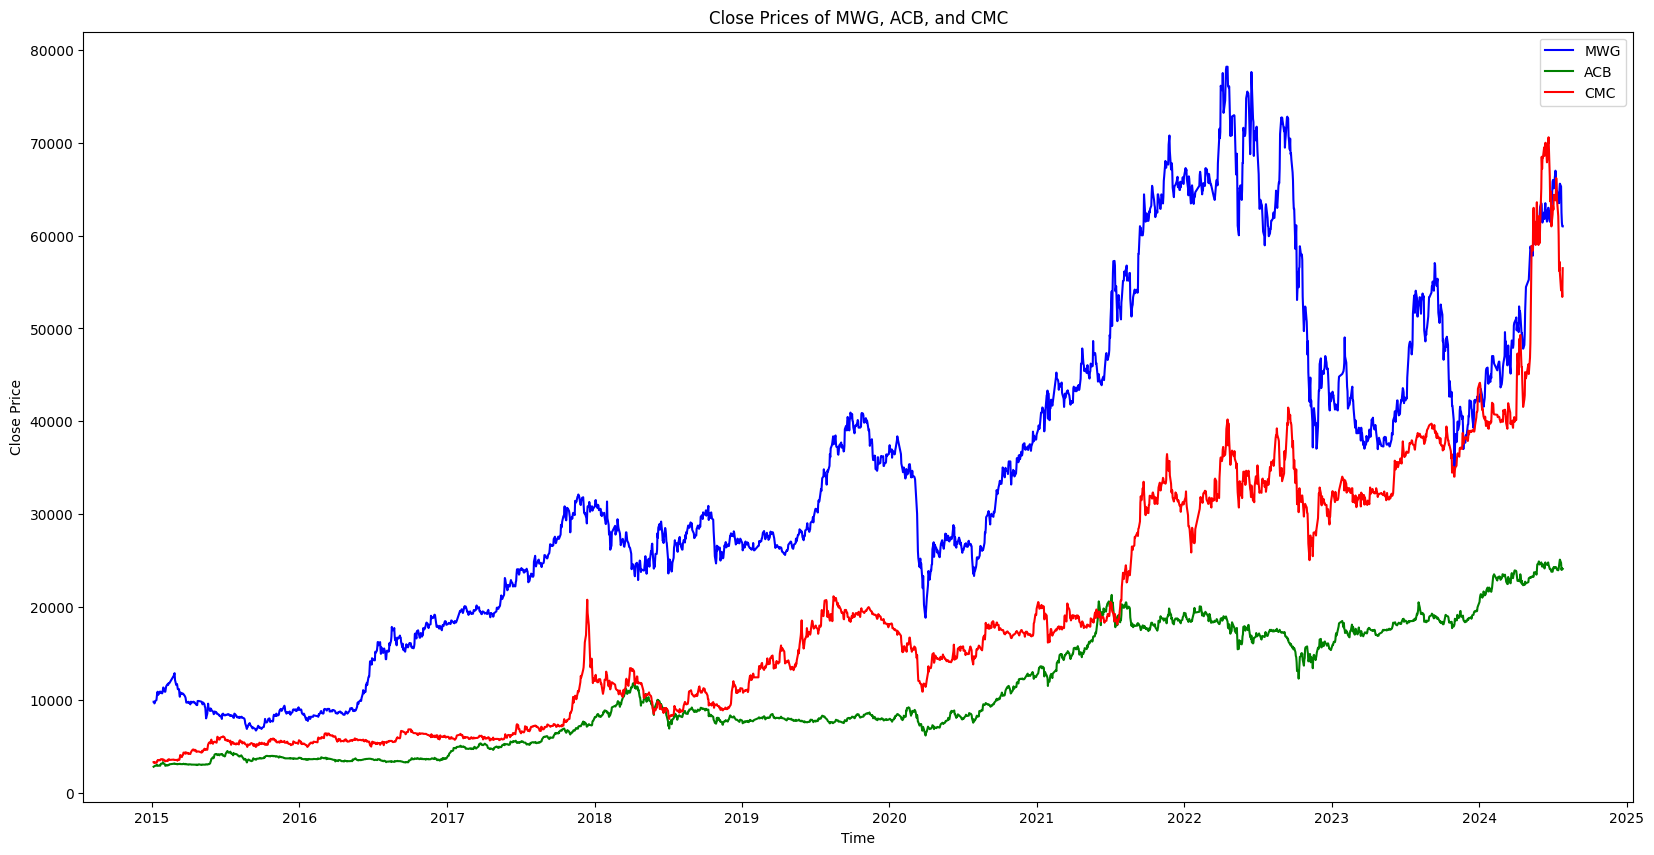

In [ ]:
# Tạo biểu đồ
plt.figure(figsize=(20, 10))

# Vẽ biểu đồ cho MWG
plt.plot(mwg.index, mwg['close'], label='MWG', color='blue')

# Vẽ biểu đồ cho ACB
plt.plot(acb.index, acb['close'], label='ACB', color='green')

# Vẽ biểu đồ cho CMC
plt.plot(cmc.index, cmc['close'], label='CMC', color='red')

# Thiết lập tiêu đề và nhãn trục
plt.title('Close Prices of MWG, ACB, and CMC')
plt.xlabel('Time')
plt.ylabel('Close Price')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()

## **Scale data to (0, 1)**

In [ ]:
scaler = MinMaxScaler()
mwg['close_scaled'] = scaler.fit_transform(mwg[['close']])
acb['close_scaled'] = scaler.fit_transform(acb[['close']])
cmc['close_scaled'] = scaler.fit_transform(cmc[['close']])

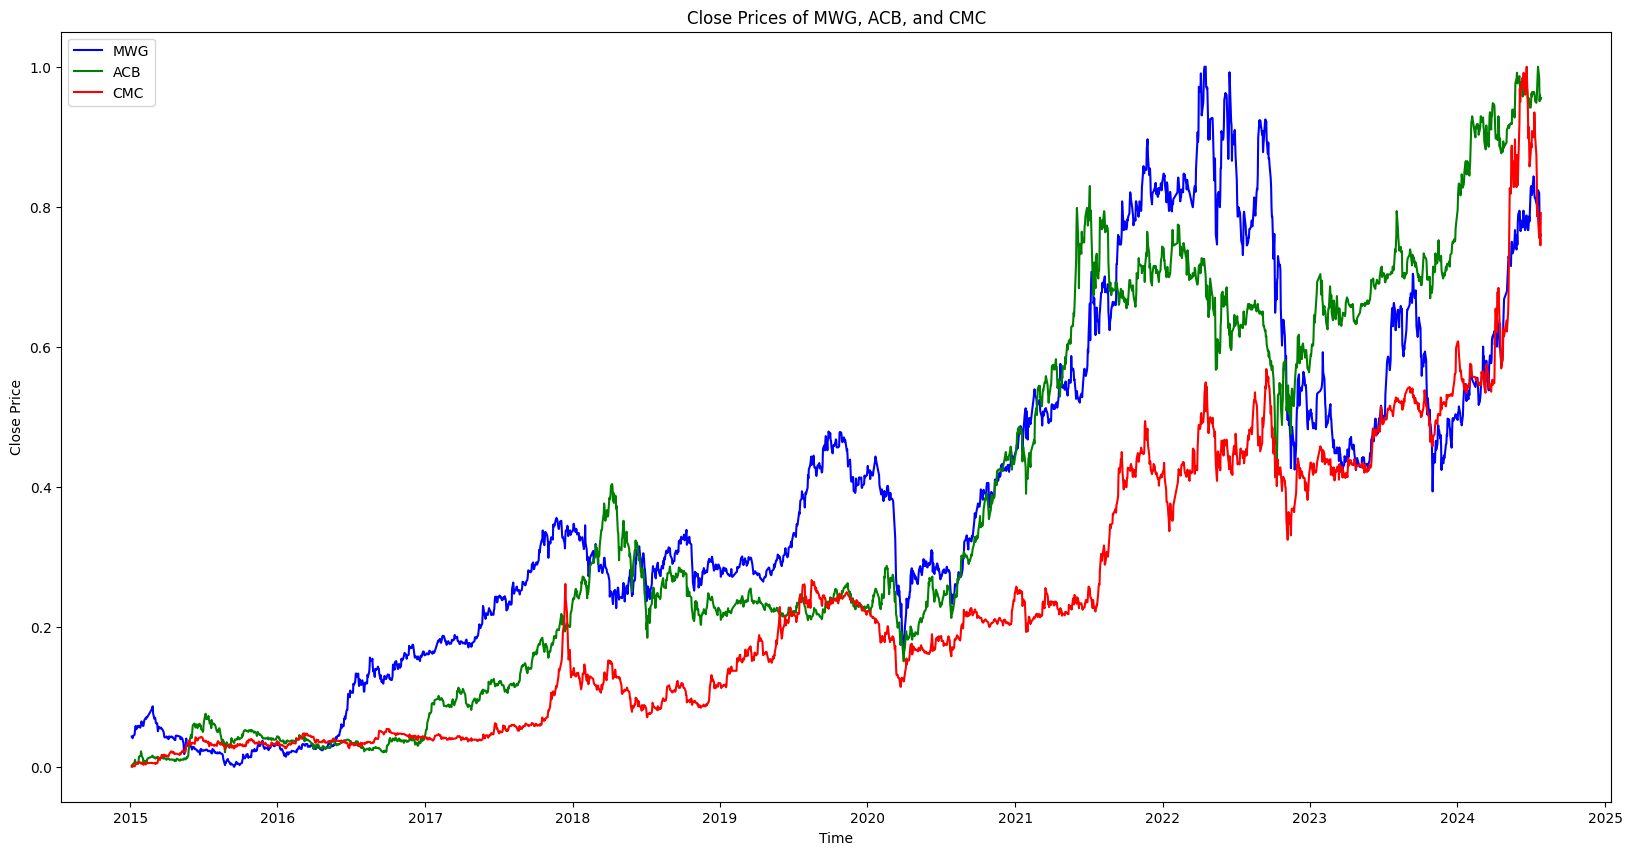

In [ ]:
# Tạo biểu đồ
plt.figure(figsize=(20, 10))

# Vẽ biểu đồ cho MWG
plt.plot(mwg.index, mwg['close_scaled'], label='MWG', color='blue')

# Vẽ biểu đồ cho ACB
plt.plot(acb.index, acb['close_scaled'], label='ACB', color='green')

# Vẽ biểu đồ cho CMC
plt.plot(cmc.index, cmc['close_scaled'], label='CMC', color='red')

# Thiết lập tiêu đề và nhãn trục
plt.title('Close Prices of MWG, ACB, and CMC')
plt.xlabel('Time')
plt.ylabel('Close Price')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()

## **Chia thành tập train - test**

In [ ]:
def train_test_split(df):
    train = df.loc['2015-01-01':'2023-12-31']
    test = df.loc['2024-01-01':'2024-07-31']
    return train, test

In [ ]:
# Chia tập huấn luyện và kiểm tra cho các chuỗi thời gian
mwg_train, mwg_test = train_test_split(mwg)
acb_train, acb_test = train_test_split(acb)
cmc_train, cmc_test = train_test_split(cmc)

## **SimpleRNN thông thường**

In [ ]:
def train_evaluate_forecast(stock_data, stock_name, learning_rate, epochs, batch_size, scaler):
    # Chuẩn bị dữ liệu
    data_train, data_test = stock_data
    X_train = data_train['close_scaled'].values.reshape(-1, 1, 1)  # Đầu vào là toàn bộ chuỗi thời gian
    y_train = data_train['close_scaled'].values  # Đầu ra vẫn là toàn bộ chuỗi thời gian
    X_test = data_test['close_scaled'].values.reshape(-1, 1, 1)  # Dữ liệu kiểm thử
    y_test = data_test['close_scaled'].values  # Giá trị kiểm thử thực tế

    # Xây dựng mô hình RNN đơn giản
    model = Sequential([
        SimpleRNN(50, activation='relu', input_shape=(1, 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Huấn luyện mô hình
    history = model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_split=0.2, batch_size=batch_size)

    # Dự báo trên tập huấn luyện
    train_predictions = model.predict(X_train)
    train_predictions_rescaled = scaler.inverse_transform(train_predictions)
    y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))

    # Dự báo trên tập test
    test_predictions = model.predict(X_test)
    test_predictions_rescaled = scaler.inverse_transform(test_predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Đánh giá và vẽ biểu đồ
    evaluate_and_plot_results(data_train.index, y_train_rescaled, train_predictions_rescaled, stock_name, 'Train')
    evaluate_and_plot_results(data_test.index, y_test_rescaled, test_predictions_rescaled, stock_name, 'Test')

    return model, history

def evaluate_and_plot_results(dates, y_true, y_pred, stock_name, dataset_type):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else None
    r2 = r2_score(y_true, y_pred)
    print(f"--- Đánh giá cho {stock_name} trên tập {dataset_type} ---")
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    if mape is not None:
        print("Mean Absolute Percentage Error (MAPE):", mape)
    else:
        print("MAPE không thể tính toán do có giá trị zero trong y_test.")
    print("R^2 Score:", r2)
    plot_results(dates, y_true, y_pred, stock_name, dataset_type)

def plot_results(dates, y_true, y_pred, stock_name, dataset_type):
    plt.figure(figsize=(10, 6))
    plt.plot(dates, y_true, label=f'Thực tế {dataset_type} ' + stock_name, color='blue')
    plt.plot(dates, y_pred, label=f'Dự đoán {dataset_type} ' + stock_name, color='red')
    plt.gcf().autofmt_xdate()
    plt.title(f'SimpleRNN dự báo giá chứng khoán cho {stock_name} trên tập ({dataset_type})')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')
    plt.legend()
    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--- Đánh giá cho MWG trên tập Train ---
Mean Squared Error (MSE): 943.9093043433492
Root Mean Squared Error (RMSE): 30.723107009925755
Mean Absolute Error (MAE): 9.558702987056739
Mean Absolute Percentage Error (MAPE): 0.030687539679620963
R^2 Score: 0.9999965377662555


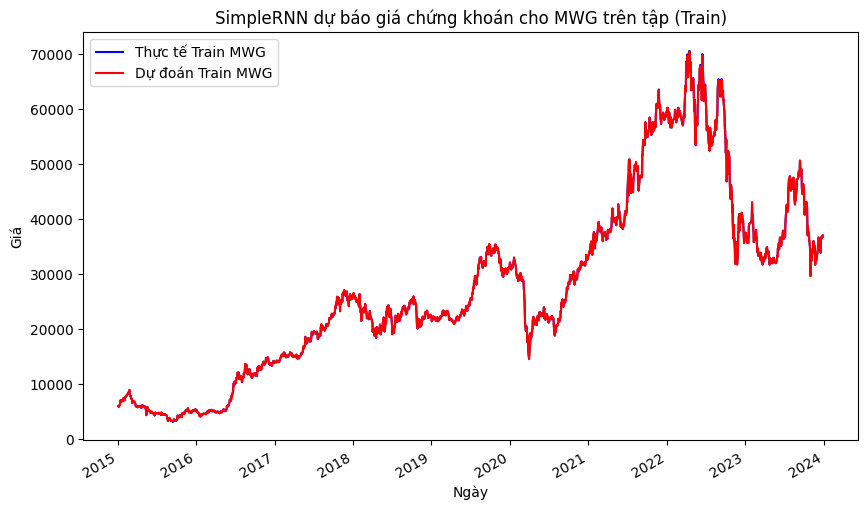

--- Đánh giá cho MWG trên tập Test ---
Mean Squared Error (MSE): 1117.6680009795896
Root Mean Squared Error (RMSE): 33.431542007206154
Mean Absolute Error (MAE): 21.171504604771222
Mean Absolute Percentage Error (MAPE): 0.0394405975765407
R^2 Score: 0.9999803406906588


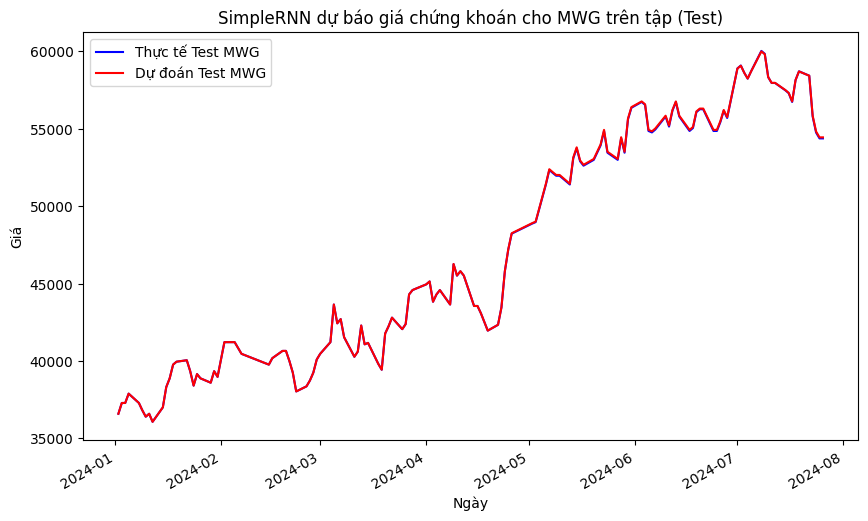

In [ ]:
model_mwg, history_mwg = train_evaluate_forecast((mwg_train, mwg_test), "MWG", 0.01, 20, 32, scaler)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--- Đánh giá cho ACB trên tập Train ---
Mean Squared Error (MSE): 49.47644029850376
Root Mean Squared Error (RMSE): 7.033949125384954
Mean Absolute Error (MAE): 4.053502617040358
Mean Absolute Percentage Error (MAPE): 0.018714746963969887
R^2 Score: 0.9999998317036054


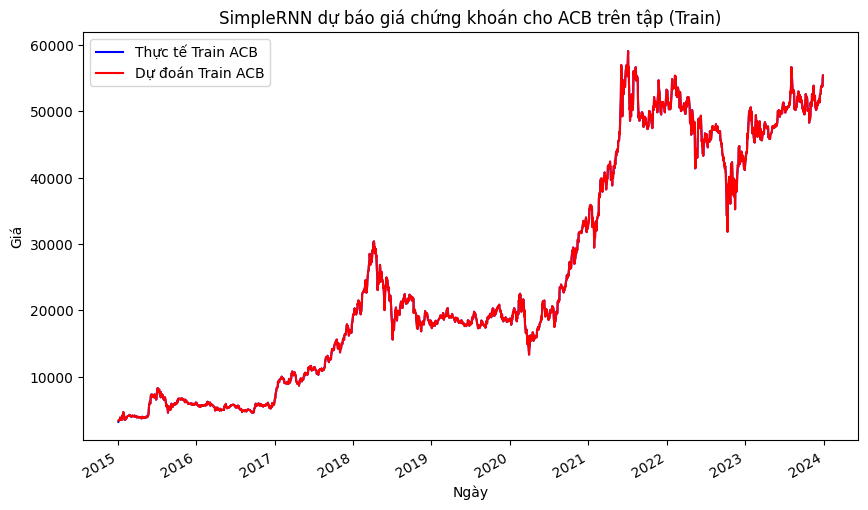

--- Đánh giá cho ACB trên tập Test ---
Mean Squared Error (MSE): 432.7786757190963
Root Mean Squared Error (RMSE): 20.80333328385373
Mean Absolute Error (MAE): 19.71540881430904
Mean Absolute Percentage Error (MAPE): 0.02986199777254036
R^2 Score: 0.9999562717356963


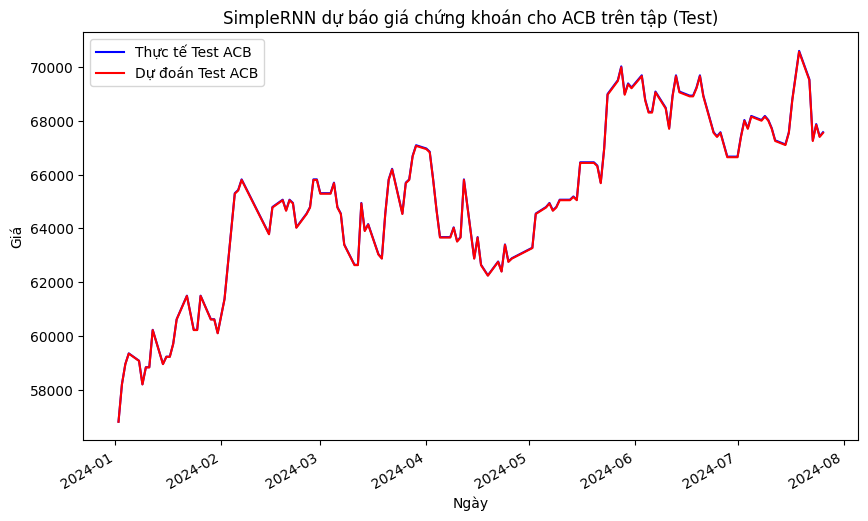

In [ ]:
model_acb, history_acb = train_evaluate_forecast((acb_train, acb_test), "ACB", 0.01, 20, 32, scaler)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--- Đánh giá cho CMC trên tập Train ---
Mean Squared Error (MSE): 128.81504445210516
Root Mean Squared Error (RMSE): 11.349671557014553
Mean Absolute Error (MAE): 4.492185546006222
Mean Absolute Percentage Error (MAPE): 0.024215841285774833
R^2 Score: 0.9999989672134025


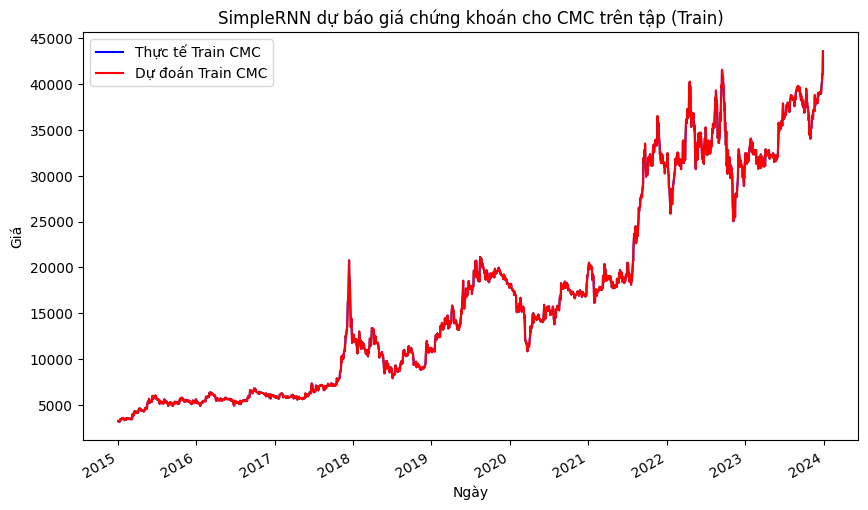

--- Đánh giá cho CMC trên tập Test ---
Mean Squared Error (MSE): 27116.706320953217
Root Mean Squared Error (RMSE): 164.6715103500093
Mean Absolute Error (MAE): 138.82301897321403
Mean Absolute Percentage Error (MAPE): 0.25091997596447313
R^2 Score: 0.9997709012487103


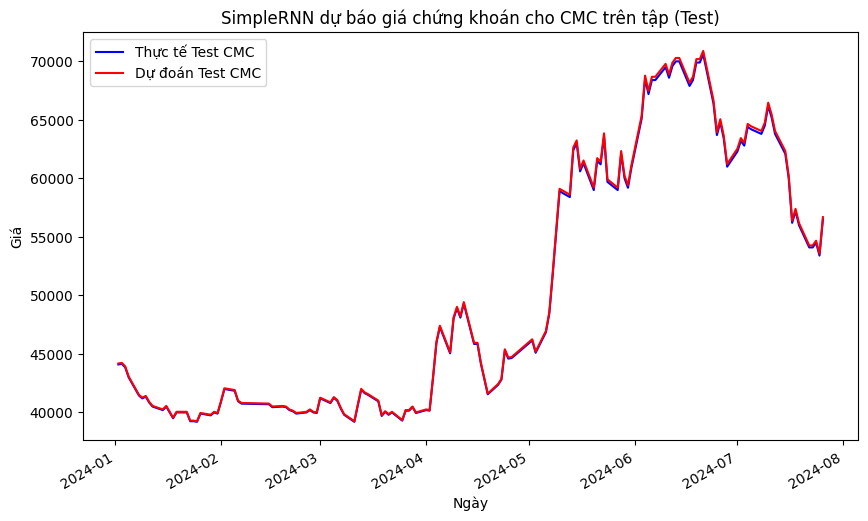

In [ ]:
model_cmc, history_cmc = train_evaluate_forecast((cmc_train, cmc_test), "CMC", 0.01, 20, 32, scaler)

## **SimpleRNN với kĩ thuật Sliding Window**

In [ ]:
def train_evaluate_forecast_sliding(stock_data, stock_name, n_steps, learning_rate, epochs, batch_size, scaler):
    def create_sequences(data, n_steps):
        X, y = [], []
        for i in range(n_steps, len(data)):
            X.append(data[i-n_steps:i])
            y.append(data[i])
        return np.array(X), np.array(y)

    # Chuẩn bị dữ liệu
    data_train, data_test = stock_data
    X_train, y_train = create_sequences(data_train['close_scaled'].values, n_steps)
    X_test, y_test = create_sequences(data_test['close_scaled'].values, n_steps)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Xây dựng mô hình
    model = Sequential([
        SimpleRNN(50, activation='relu', input_shape=(n_steps, 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Huấn luyện mô hình
    history = model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_split=0.2, batch_size=batch_size)

    # Dự báo trên tập huấn luyện
    train_predictions = model.predict(X_train)
    train_predictions_rescaled = scaler.inverse_transform(train_predictions)
    y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))

    # Dự báo trên tập test
    test_predictions = model.predict(X_test)
    test_predictions_rescaled = scaler.inverse_transform(test_predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Đánh giá và vẽ biểu đồ
    evaluate_and_plot_results(data_train.index, y_train_rescaled, train_predictions_rescaled, stock_name, 'Train', n_steps)
    evaluate_and_plot_results(data_test.index, y_test_rescaled, test_predictions_rescaled, stock_name, 'Test', n_steps)

    return model, history

def evaluate_and_plot_results(dates, y_true, y_pred, stock_name, dataset_type, n_steps):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else None
    r2 = r2_score(y_true, y_pred)
    print(f"--- Đánh giá cho {stock_name} trên tập {dataset_type} ---")
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    if mape is not None:
        print("Mean Absolute Percentage Error (MAPE):", mape)
    else:
        print("MAPE không thể tính toán do có giá trị zero trong y_test.")
    print("R^2 Score:", r2)

    # Điều chỉnh ngày
    adjusted_dates = dates[n_steps:]  # Bỏ qua n_steps phần tử đầu tiên của dates để khớp với y_true và y_pred

    plot_results(adjusted_dates, y_true, y_pred, stock_name, dataset_type)

def plot_results(dates, y_true, y_pred, stock_name, dataset_type):
    plt.figure(figsize=(10, 6))
    plt.plot(dates, y_true, label=f'Thực tế {dataset_type} ' + stock_name, color='blue')
    plt.plot(dates, y_pred, label=f'Dự đoán {dataset_type} ' + stock_name, color='red')
    plt.gcf().autofmt_xdate()
    plt.title(f'SimpleRNN kết hợp kỹ thuật Sliding Window dự báo giá chứng khoán cho {stock_name} trên tập ({dataset_type})')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')
    plt.legend()
    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--- Đánh giá cho MWG trên tập Train ---
Mean Squared Error (MSE): 786302.9416294572
Root Mean Squared Error (RMSE): 886.7372449770322
Mean Absolute Error (MAE): 625.6580781084742
Mean Absolute Percentage Error (MAPE): 3.932366232166625
R^2 Score: 0.997111189424505


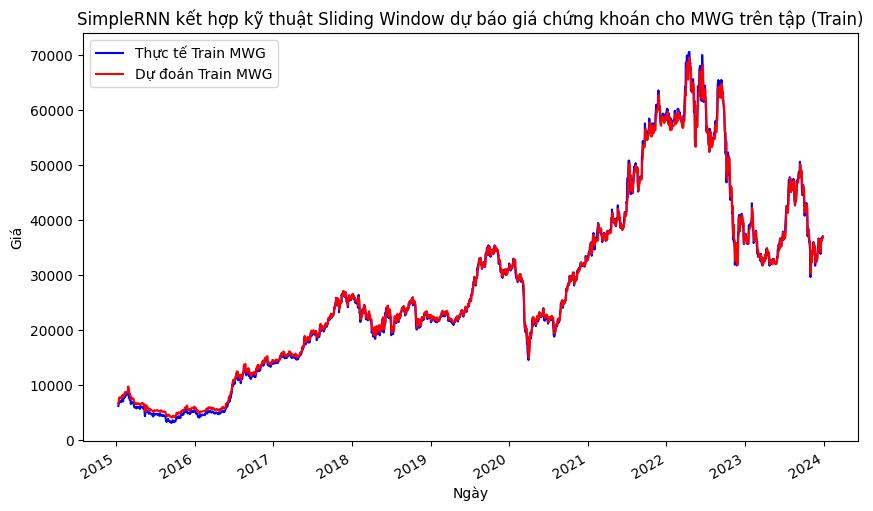

--- Đánh giá cho MWG trên tập Test ---
Mean Squared Error (MSE): 1141131.531238354
Root Mean Squared Error (RMSE): 1068.2375818320352
Mean Absolute Error (MAE): 823.076717236467
Mean Absolute Percentage Error (MAPE): 1.7364759746444236
R^2 Score: 0.9792498413309322


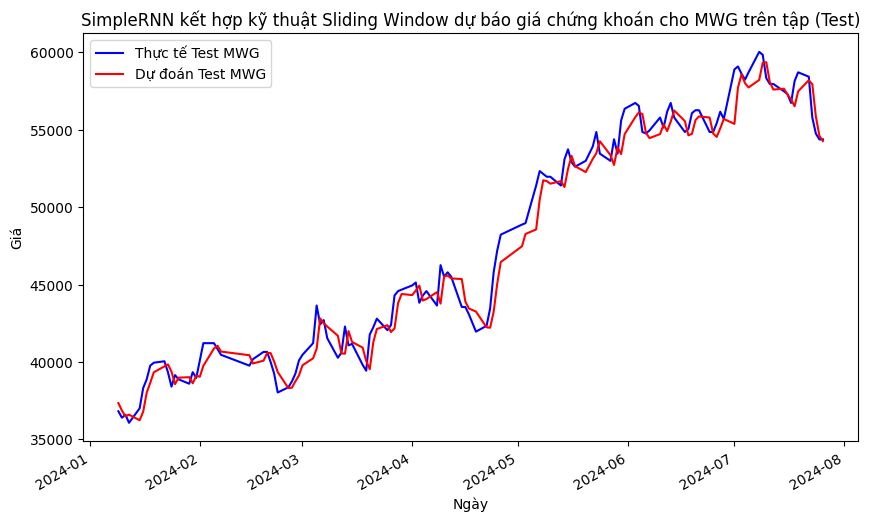

In [ ]:
model_mwg, history_mwg = train_evaluate_forecast_sliding((mwg_train, mwg_test), "MWG", 5, 0.01, 20, 32, scaler)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--- Đánh giá cho ACB trên tập Train ---
Mean Squared Error (MSE): 453676.4258007362
Root Mean Squared Error (RMSE): 673.5550651585482
Mean Absolute Error (MAE): 413.349602174242
Mean Absolute Percentage Error (MAPE): 1.8541243216558572
R^2 Score: 0.9984524514622556


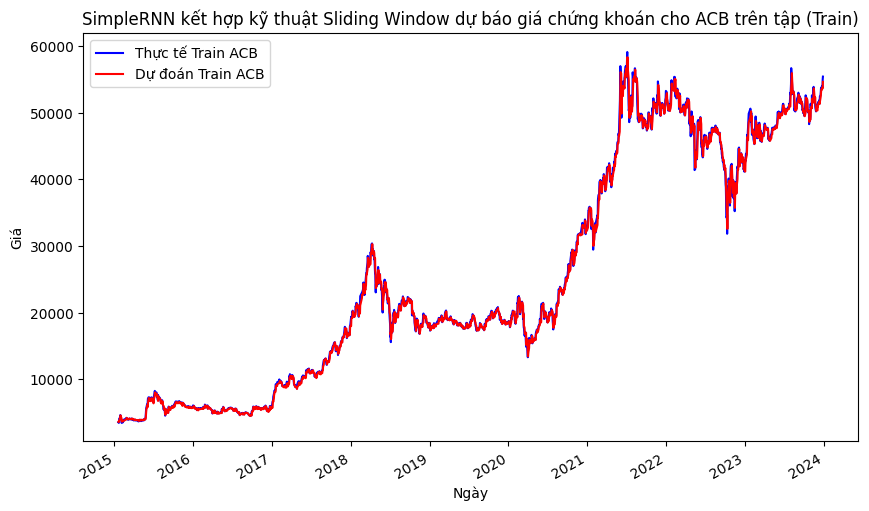

--- Đánh giá cho ACB trên tập Test ---
Mean Squared Error (MSE): 863453.9597363529
Root Mean Squared Error (RMSE): 929.2222337720686
Mean Absolute Error (MAE): 690.1601526404584
Mean Absolute Percentage Error (MAPE): 1.0516084166711102
R^2 Score: 0.8814762804541708


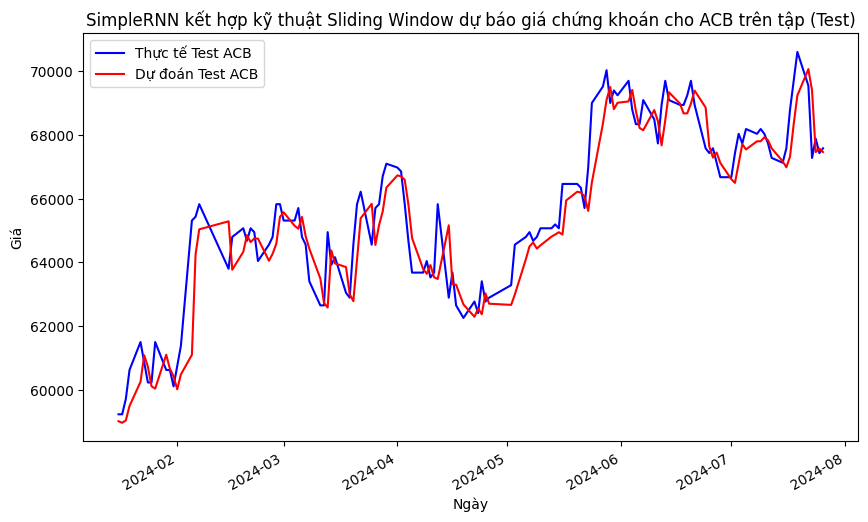

In [ ]:
model_acb, history_acb = train_evaluate_forecast_sliding((acb_train, acb_test), "ACB", 10, 0.01, 20, 32, scaler)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--- Đánh giá cho CMC trên tập Train ---
Mean Squared Error (MSE): 242171.6177063145
Root Mean Squared Error (RMSE): 492.1093554346579
Mean Absolute Error (MAE): 310.1246046208548
Mean Absolute Percentage Error (MAPE): 1.9718454590244565
R^2 Score: 0.9980538149197966


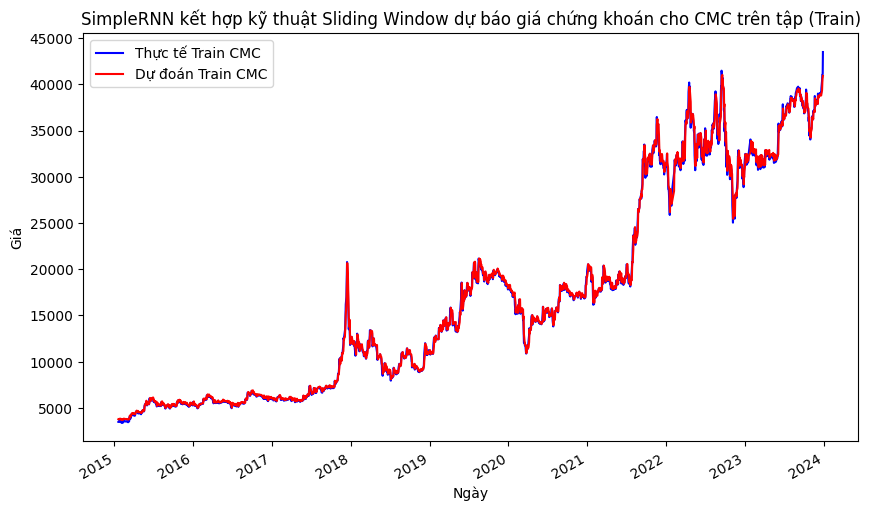

--- Đánh giá cho CMC trên tập Test ---
Mean Squared Error (MSE): 3134674.080225901
Root Mean Squared Error (RMSE): 1770.5010816788283
Mean Absolute Error (MAE): 1259.8983473557696
Mean Absolute Percentage Error (MAPE): 2.321864306703243
R^2 Score: 0.9741806085592131


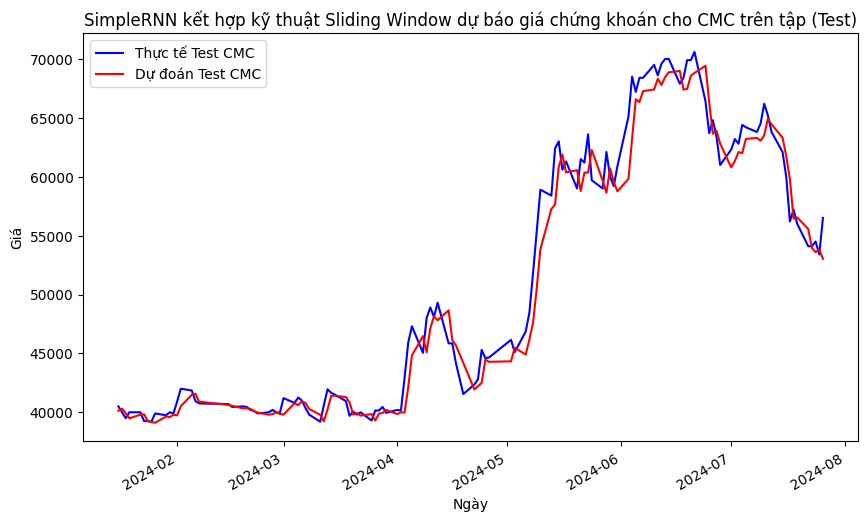

In [ ]:
model_cmc, history_cmc = train_evaluate_forecast_sliding((cmc_train, cmc_test), "CMC", 10, 0.01, 20, 32, scaler)